In [1]:
import torch
import pandas as pd

In [2]:
#extract korean dataset
from load_korean_data import extract_zips

extract_zips()

Done extracting Korean data


In [2]:

df_madalena_comfort = pd.read_csv('datasets/madalena/madalena_comfort.csv')

df_madalena_comfort.head()

,date,Room,CO2[ppm],PM4[ug/m3],Lighting[lux],T_in[°C],RH [%],PM10[ug/m3],PM2_5[ug/m3],PM1[ug/m3],PM0_5[ug/m3],T_out [°C]
0,2024-07-01 00:00:00,E145,624.23,65.43,0.00,28.46,55.51,65.44,65.42,65.22,56.81,24.5
1,2024-07-01 01:00:00,E145,629.00,66.77,0.00,28.48,56.39,66.78,66.76,66.56,57.97,24.0
2,2024-07-01 02:00:00,E145,640.13,67.78,0.00,28.45,56.74,67.79,67.77,67.57,58.85,22.3
3,2024-07-01 03:00:00,E145,639.77,68.00,0.00,28.39,57.08,68.01,67.98,67.78,59.04,22.0
4,2024-07-01 04:00:00,E145,643.31,67.25,0.03,28.35,57.57,67.26,67.24,67.04,58.39,21.5


In [3]:
from glob import glob
import os
import gc


def optimize_memory(df):
    for col in df.select_dtypes(include=["int64", "float64"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")  
        df[col] = pd.to_numeric(df[col], downcast="float")   
    return df


In [6]:
def process_parquet(file):
    df = pd.read_parquet(file, engine="pyarrow")
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")  
    df = df.set_index("timestamp").sort_index()
    df = df[~df.index.duplicated(keep="first")]
    time_diffs = df.index.to_series().diff().dropna()
    detected_freq = time_diffs.mode()[0]  
    detected_freq_str = f"{int(detected_freq.total_seconds() * 1000)}ms"
    df = df.asfreq(detected_freq_str)
    df = df.interpolate(method="time")
    df_resampled = df.resample("1min").mean()
    return df_resampled

save_dir = "datasets/korean_processed"
def merge_daily_files(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith(".parquet.gzip")]

    dfs = {}  

    for file in files:
        file_path = os.path.join(folder_path, file)
        df = process_parquet(file_path) 
        device_name = file.split("_", 1)[1].split(".parquet")[0]
        df = df.rename(columns={
            "active_power": f"{device_name}_active_power",
            "reactive_power": f"{device_name}_reactive_power"
        })
        dfs[device_name] = df  

    merged_df = list(dfs.values())[0]  

    for df in list(dfs.values())[1:]:
        merged_df = merged_df.merge(df, left_index=True, right_index=True, how="outer")

    del dfs
    gc.collect()
    return merged_df

def create_korean_files(path = "datasets/korean_extracted"):
    for folder in os.listdir(path):
        full_path = os.path.join(path, folder)
        for subfolder in os.listdir(full_path):
            full_subpath = os.path.join(full_path, subfolder)
            house_dfs = []
            for day_folder in os.listdir(full_subpath):
                day_path = os.path.join(full_subpath, day_folder)
                merged_df = merge_daily_files(day_path)
                merged_df = merged_df.fillna(0)
                print(f"Finished Day {day_path}")
                house_dfs.append(merged_df)
                del merged_df
                gc.collect()
            house_final_df = pd.concat(house_dfs)
            if house_final_df.index.name == "timestamp":
                house_final_df = house_final_df.reset_index()
            house_final_df = house_final_df.sort_values(by='timestamp').set_index('timestamp')
            house_final_df = house_final_df.fillna(0)

            house_final_df.to_csv(f"{save_dir}/{folder}.csv")
            del house_final_df
            del house_dfs
            gc.collect()
        
# merged_df = merge_daily_files(full_timestamp_path)
# merged_df = merged_df.fillna(0)
# merged_df.to_csv("datasets/korean_processed/merged_daily_data.csv")
create_korean_files()


Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161101
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161102
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161103
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161104
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161105
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161106
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161107
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161109
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161110
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161111
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161112
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161113
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161114
Finished Day datasets/korean_extracted\enertalk-dataset-00\00\20161115
Finish

In [19]:
houses = [f for f in os.listdir("datasets/korean_processed") if f.endswith(".csv")]
house_dfs = []
for house in houses:
    df = pd.read_csv(os.path.join("datasets/korean_processed", house), parse_dates=["timestamp"], index_col="timestamp")
    df['house_id'] = house.split("-")[2].split(".")[0]
    house_dfs.append(df)

full_df = pd.concat(house_dfs)
full_df.head()

,total_active_power,total_reactive_power,washing-machine_active_power,washing-machine_reactive_power,rice-cooker_active_power,rice-cooker_reactive_power,water-purifier_active_power,water-purifier_reactive_power,microwave_active_power,microwave_reactive_power,kimchi-fridge_active_power,kimchi-fridge_reactive_power,TV_active_power,TV_reactive_power,fridge_active_power,fridge_reactive_power,house_id
timestamp,,,,,,,,,,,,,,,,,
2016-11-01 00:00:00,226.278702,-41.480791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,00
2016-11-01 00:01:00,426.839889,-85.463171,0.117980,6.110303,0.000000,0.000000,340.030000,-1.647143,0.475614,-1.545066,0.453393,-3.483571,0.0,0.0,0.0,0.0,00
2016-11-01 00:02:00,417.073146,-142.700712,0.055135,5.976013,0.253236,0.018027,338.550340,-1.636741,0.496926,-1.530755,0.555059,-3.496886,0.0,0.0,0.0,0.0,00
2016-11-01 00:03:00,147.948077,-145.353986,0.034107,6.011007,0.218430,0.029089,68.882708,-0.310016,0.512941,-1.562262,0.522887,-3.555151,0.0,0.0,0.0,0.0,00
2016-11-01 00:04:00,68.593354,-145.734066,0.045174,6.006146,0.264247,0.036712,2.012237,0.099879,0.517540,-1.613452,0.534455,-3.589693,0.0,0.0,0.0,0.0,00


In [20]:
print(full_df.isnull().sum())
full_df = full_df.fillna(0)
print(full_df.isnull().sum())

total_active_power                      0
total_reactive_power                    0
washing-machine_active_power       576412
washing-machine_reactive_power     576412
rice-cooker_active_power           698556
rice-cooker_reactive_power         698556
water-purifier_active_power       1317203
water-purifier_reactive_power     1317203
microwave_active_power            1207528
microwave_reactive_power          1207528
kimchi-fridge_active_power         484048
kimchi-fridge_reactive_power       484048
TV_active_power                    478424
TV_reactive_power                  478424
fridge_active_power                507836
fridge_reactive_power              507836
house_id                                0
dtype: int64
total_active_power                0
total_reactive_power              0
washing-machine_active_power      0
washing-machine_reactive_power    0
rice-cooker_active_power          0
rice-cooker_reactive_power        0
water-purifier_active_power       0
water-purifier_reacti

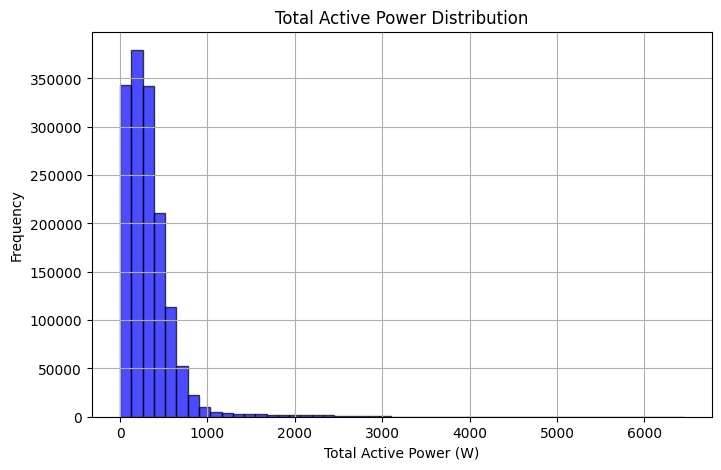

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(full_df['total_active_power'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Total Active Power (W)')
plt.ylabel('Frequency')
plt.title('Total Active Power Distribution')
plt.grid()
plt.show()

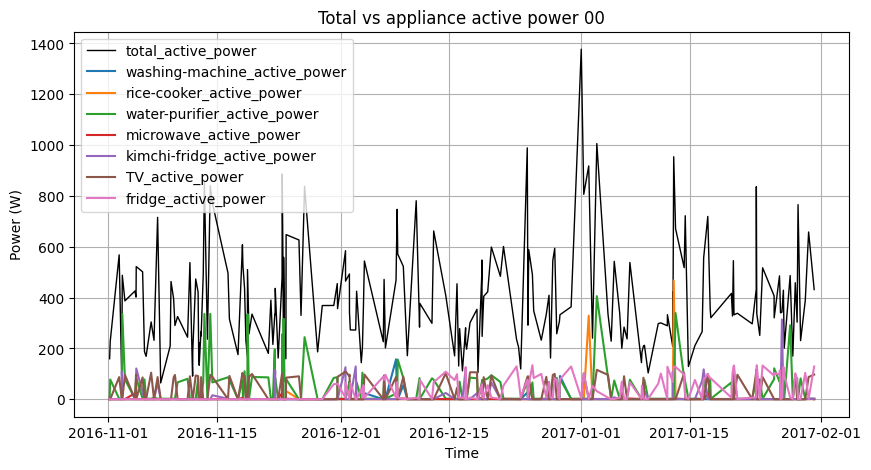

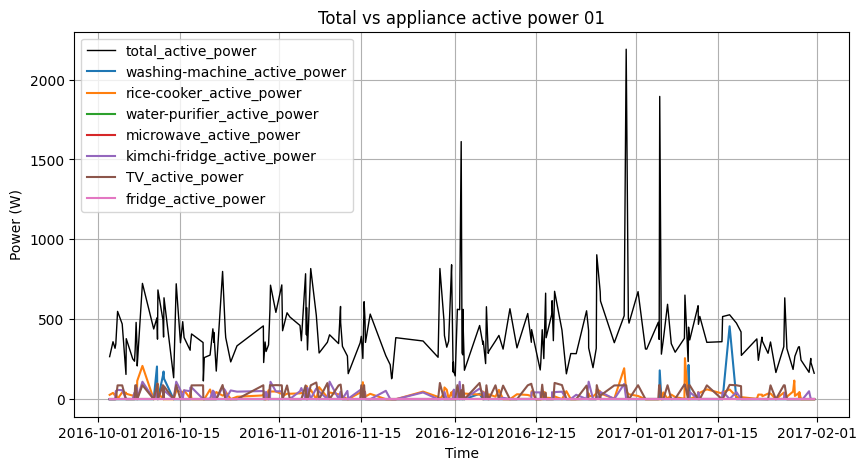

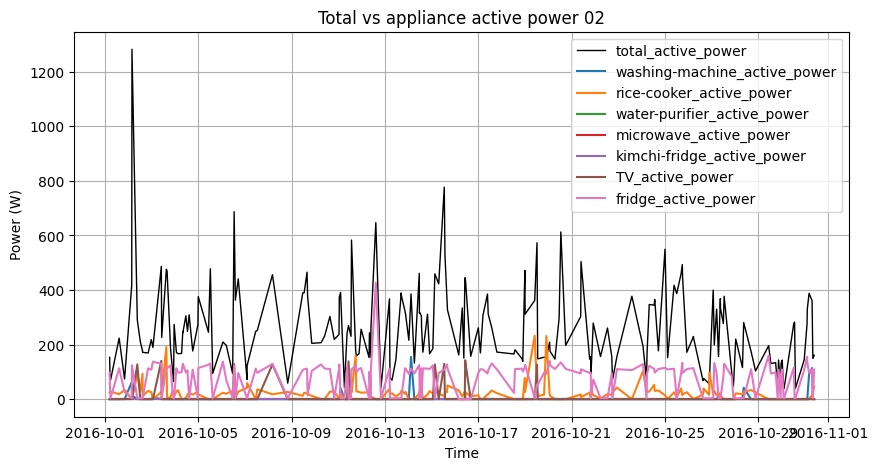

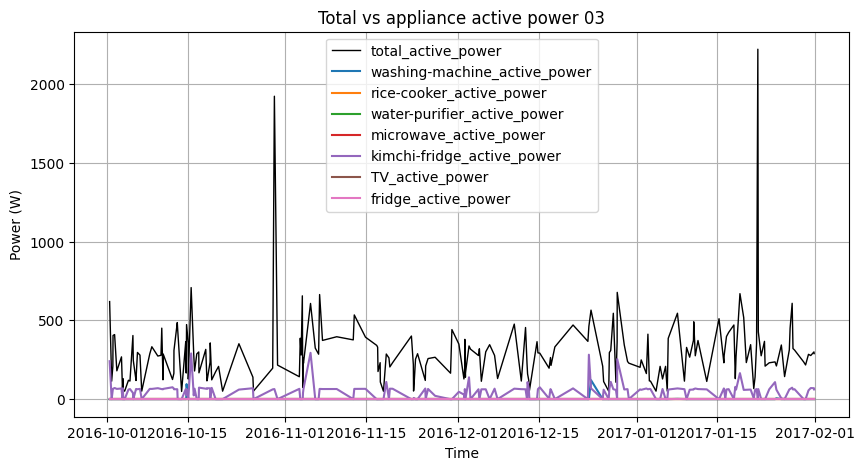

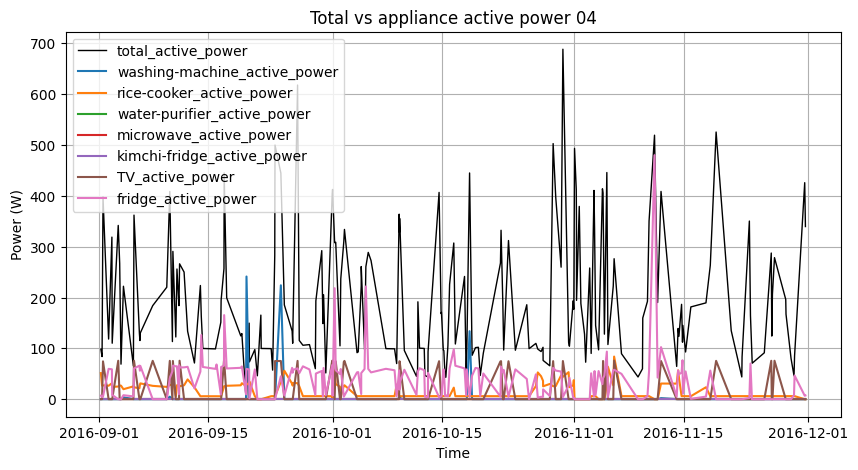

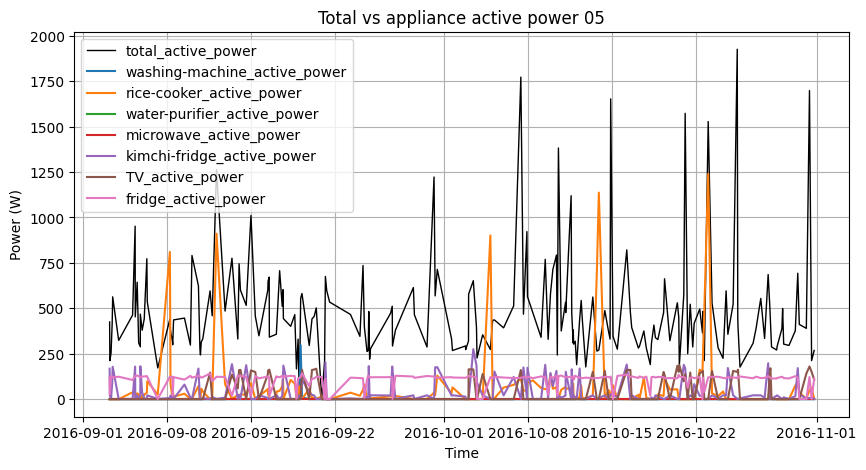

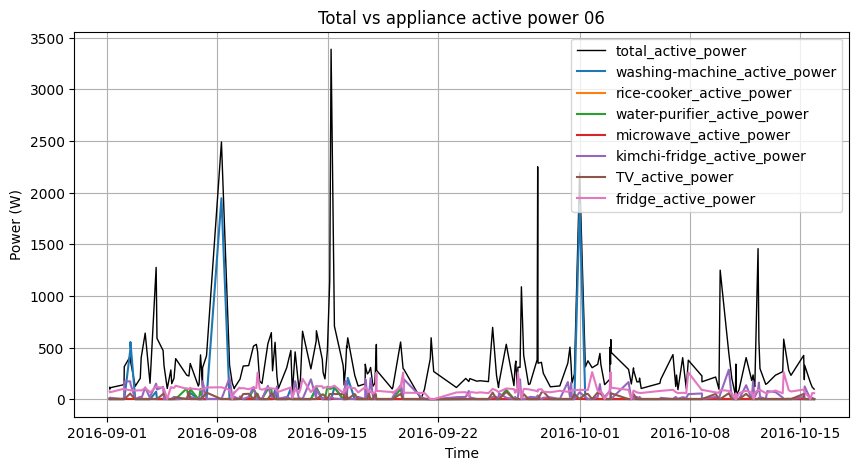

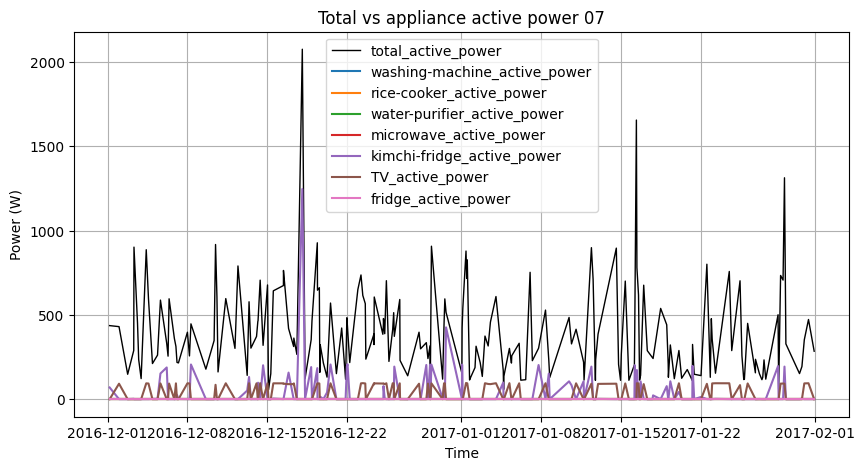

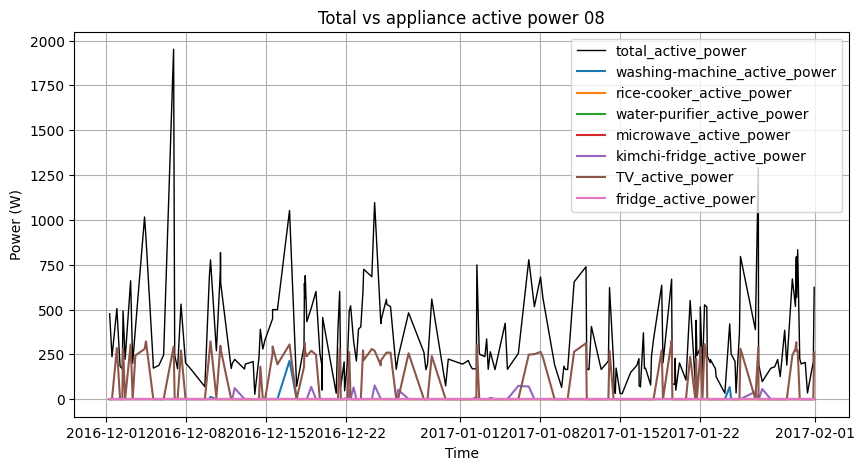

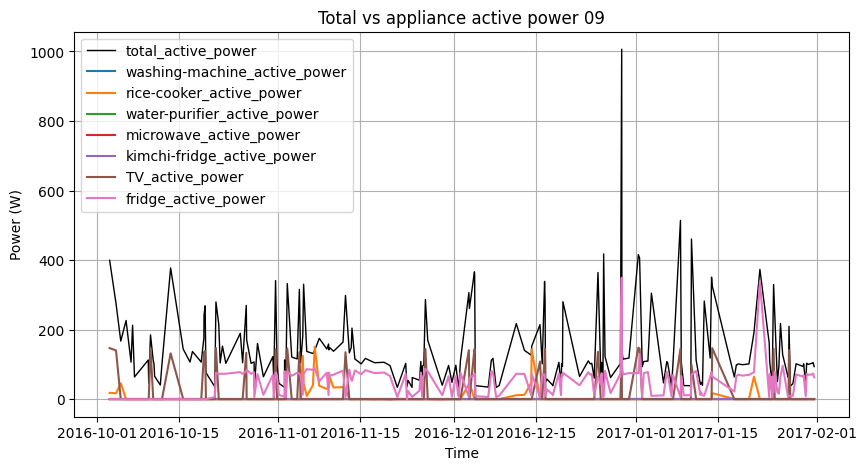

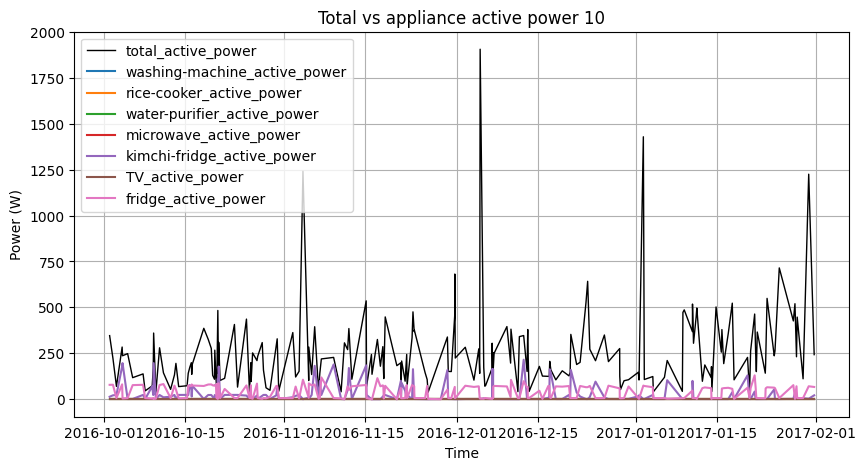

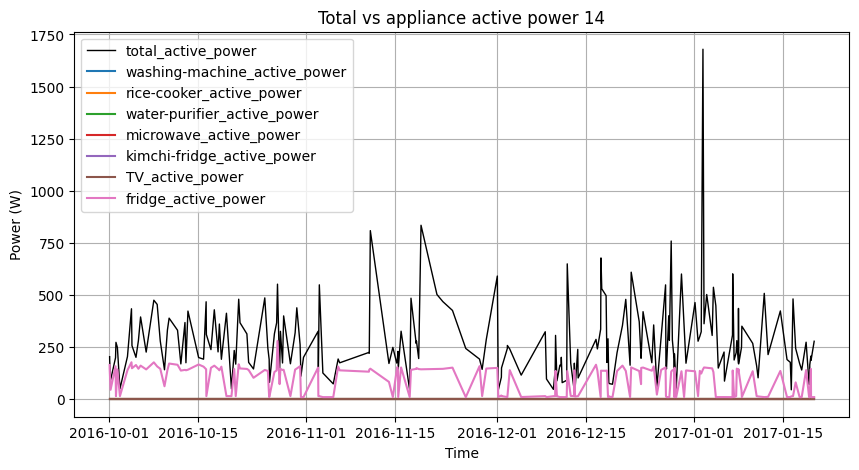

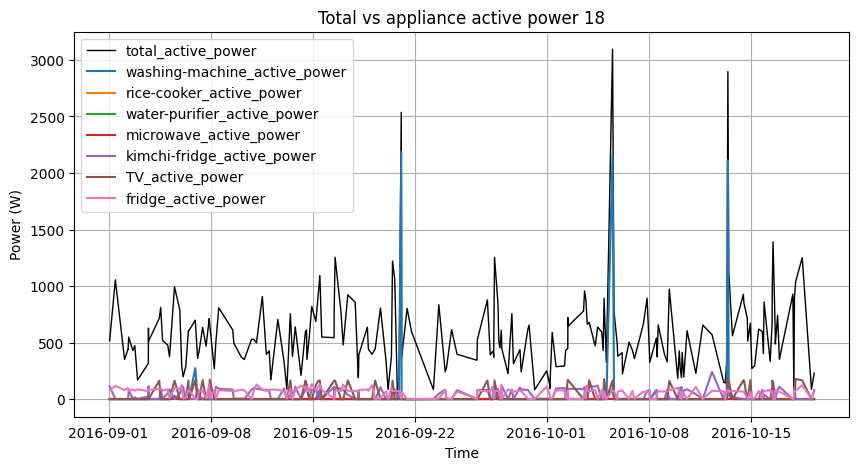

In [9]:
appliance_cols = [col for col in full_df.columns if "active" in col and "total" not in col and 'reactive' not in col]
#take rows from each house equally to understand appliance usage
house_ids = full_df['house_id'].unique()
for house in house_ids:
    house_data = full_df[full_df['house_id'] == house].sample(n=200, random_state=42, replace=False).sort_index()
    plt.figure(figsize=(10, 5))
    plt.plot(house_data.index, house_data['total_active_power'], label='total_active_power', color='black', linewidth=1)
    
    for appliance in appliance_cols:
        plt.plot(house_data.index, house_data[appliance], label=appliance)
    plt.xlabel('Time')
    plt.ylabel('Power (W)')
    plt.title(f'Total vs appliance active power {house}')
    plt.legend()
    plt.grid()
    plt.show()
    del house_data
    gc.collect()


In [21]:
total_appliance_power = full_df[appliance_cols].sum(axis=1)
incorrect_rows = full_df[total_appliance_power > full_df['total_active_power']]
print(f"Number of rows with incorrect total active power: {len(incorrect_rows)}")

print(incorrect_rows[['total_active_power'] + appliance_cols].head(10))

Number of rows with incorrect total active power: 11781
                     total_active_power  washing-machine_active_power  \
timestamp                                                               
2016-11-01 03:50:00          192.580992                      0.033399   
2016-11-01 23:54:00         1977.683552                   1923.741560   
2016-11-02 00:00:00         1797.644496                   1871.084143   
2016-11-02 21:48:00          281.087637                      0.041890   
2016-11-02 23:59:00          131.707128                      0.033117   
2016-11-03 17:02:00          303.815638                      0.056307   
2016-11-03 20:18:00          265.516906                      0.051015   
2016-11-04 02:34:00          562.683289                      0.051165   
2016-11-05 14:12:00          286.878789                      0.038900   
2016-11-05 18:47:00          221.316231                      0.054694   

                     rice-cooker_active_power  water-purifier_activ

In [22]:
import numpy as np

def scale_incorrect_appliance_power(row):
    total_power = row["total_active_power"]
    appliance_power = row[appliance_cols].sum()
    #downscale appliance to match total power
    if appliance_power > total_power:  
        scale_factor = total_power / appliance_power
        row[appliance_cols] = row[appliance_cols] * scale_factor  
    return row
df_corrected = full_df.copy()
df_corrected.loc[total_appliance_power > full_df['total_active_power'], :] = df_corrected.loc[total_appliance_power > df_corrected['total_active_power']].apply(scale_incorrect_appliance_power, axis=1)
new_total_appliance_power = df_corrected[appliance_cols].sum(axis=1)
print(f"Remaining issue count: {(new_total_appliance_power > df_corrected['total_active_power']).sum()}")



Remaining issue count: 2006


In [23]:
zero_power_rows = df_corrected[df_corrected['total_active_power'] == 0]
print(f"Number of rows with zero total active power: {len(zero_power_rows)}")
df_corrected.loc[df_corrected["total_active_power"] == 0, appliance_cols] = 0
new_total_appliance_power = df_corrected[appliance_cols].sum(axis=1)
print(f"Remaining issue count: {(new_total_appliance_power > df_corrected['total_active_power']).sum()}")


Number of rows with zero total active power: 2557
Remaining issue count: 2006


In [25]:
df_corrected.to_csv("datasets/korean_sample.csv")
df_corrected.head()

,total_active_power,total_reactive_power,washing-machine_active_power,washing-machine_reactive_power,rice-cooker_active_power,rice-cooker_reactive_power,water-purifier_active_power,water-purifier_reactive_power,microwave_active_power,microwave_reactive_power,kimchi-fridge_active_power,kimchi-fridge_reactive_power,TV_active_power,TV_reactive_power,fridge_active_power,fridge_reactive_power,house_id
timestamp,,,,,,,,,,,,,,,,,
2016-11-01 00:00:00,226.278702,-41.480791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,00
2016-11-01 00:01:00,426.839889,-85.463171,0.117980,6.110303,0.000000,0.000000,340.030000,-1.647143,0.475614,-1.545066,0.453393,-3.483571,0.0,0.0,0.0,0.0,00
2016-11-01 00:02:00,417.073146,-142.700712,0.055135,5.976013,0.253236,0.018027,338.550340,-1.636741,0.496926,-1.530755,0.555059,-3.496886,0.0,0.0,0.0,0.0,00
2016-11-01 00:03:00,147.948077,-145.353986,0.034107,6.011007,0.218430,0.029089,68.882708,-0.310016,0.512941,-1.562262,0.522887,-3.555151,0.0,0.0,0.0,0.0,00
2016-11-01 00:04:00,68.593354,-145.734066,0.045174,6.006146,0.264247,0.036712,2.012237,0.099879,0.517540,-1.613452,0.534455,-3.589693,0.0,0.0,0.0,0.0,00
